## Bivariate Mixed Outcome Model: Poisson and Bernoulli VC Run-time and MSE Results 

In this example, $y_{i1} \sim Poisson(\mu_{i1}(\mathbf{\beta_1}))$ and $y_{i2} \sim Bernoulli(\mu_{i2}(\mathbf{\beta_2}))$

We simulate three fixed effects for each outcome, $\beta_1 \sim rand(p)$ and $\beta_2 \sim$ rand(Uniform(-0.2, 0.2), p) where p = 3 fixed effects.

In this example we have Poisson and Bernoulli base distribution with Log and Logit Link functions and covariance matrix $\Gamma$ structured under VC covariance with $\theta = 0.1$

We run each scenario 100 times.

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using Random, Roots, SpecialFunctions, DataFrames

┌ Info: Precompiling GLMCopula [c47b6ae2-b804-4668-9957-eb588c99ffbc]
└ @ Base loading.jl:1342


In [3]:
p  = 3    # number of fixed effects, including intercept

# true parameter values
Random.seed!(12345)
# β1true = rand(Uniform(-0.2, 0.2), p)
β1true = rand(p)
Random.seed!(1234)
β2true = rand(Uniform(-0.2, 0.2), p)
βtrue = [β1true; β2true]
θtrue = [0.1]

# generate data
trueparams = [βtrue; θtrue] #hold true parameters

#simulation parameters
samplesizes = [100; 1000; 10000]
ns = [2]
nsims = 100

100

In [4]:
@info "reading in the files with results"
fittimes = vec(readdlm("fittimes_bivariate_mixed_poisson_bernoulli_vcm$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[4]:1


300-element Vector{Float64}:
 0.216490901
 0.202812125
 0.078881281
 0.090183782
 0.083299738
 0.121866027
 0.175867272
 0.118578357
 0.126995067
 0.132422659
 0.173973425
 0.150916233
 0.172874152
 ⋮
 4.367453789
 4.060357754
 5.714808297
 5.352851842
 5.165841041
 5.149139985
 2.186308447
 3.929556019
 5.130852982
 4.371689096
 2.43182499
 5.672430159

In [6]:
#simulation parameters
@info "making results table"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes)
timedf = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf, Dict(:fittimes_function => "se"))
timedf[!, :nobs] = Meta.parse.(timedf[!, :samplesize]) .* Meta.parse.(timedf[!, :obssize])
timedf[!, :fitmin] = timedf[!, :fittime] - timedf[!, :se]
timedf[!, :fitmax] = timedf[!, :fittime] + timedf[!, :se]
timedf[!, :perobsratio] = timedf[!, :fittime] ./ timedf[!, :nobs]
timedf

┌ Info: making results table
└ @ Main In[6]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,0.155026,0.00519032,200,0.149836,0.160216,0.00077513
2,1000,2,0.412125,0.0110729,2000,0.401052,0.423198,0.000206062
3,10000,2,4.15631,0.121124,20000,4.03518,4.27743,0.000207815


┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


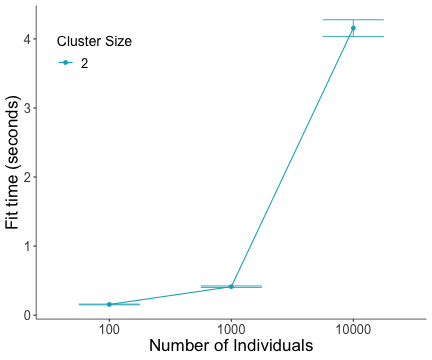

RObject{VecSxp}


In [7]:
########### plot the runtimes
using RCall
@rput timedf

R"""
library(ggplot2)
timedf$obssize = factor(timedf$obssize, levels = c('2'))
timedf$samplesize = factor(timedf$samplesize, levels = c('100', '1000', '10000'))

fittime_1 = ggplot(timedf, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#05aec0")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Cluster Size")
"""

In [8]:
R"""
ggsave('fittime_nobs_biv_mixed_poisson_bernoulli.png', fittime_1, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "fittime_nobs_biv_mixed_poisson_bernoulli.png"


In [9]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βθcoverage = readdlm("beta_sigma_coverage_bivariate_mixed_poisson_bernoulli_vcm$(nsims)reps_sim.csv", ',')

m = 1

covdf = DataFrame(Matrix(transpose(βθcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:2p]; ["θ"]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:2p]; ["θ"]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3,β4
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 100 ni: 2,"(0.66, 0.0476095)","(0.69, 0.0464823)","(0.72, 0.0451261)","(0.71, 0.0456048)"
2,N: 1000 ni: 2,"(0.62, 0.0487832)","(0.77, 0.0422953)","(0.75, 0.0435194)","(0.6, 0.0492366)"
3,N: 10000 ni: 2,"(0.74, 0.0440844)","(0.85, 0.035887)","(0.83, 0.0377525)","(0.74, 0.0440844)"


In [11]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresult_1 = vec(readdlm("mse_beta_bivariate_mixed_poisson_bernoulli_vcm$(nsims)reps_sim.csv", ','))
θMseResult_1 = vec(readdlm("mse_Sigma_bivariate_mixed_poisson_bernoulli_vcm$(nsims)reps_sim.csv", ','))
βθcoverage_1 = readdlm("beta_sigma_coverage_bivariate_mixed_poisson_bernoulli_vcm$(nsims)reps_sim.csv", ',')

samplesizesrobust = samplesizes
nsrobust = ns
nsimsrobust = nsims

p = 3
sample_sizesrobust = repeat(string.(samplesizesrobust), inner = nsimsrobust * length(nsrobust))
obs_sizesrobust = repeat(string.(nsrobust), inner = nsimsrobust, outer = length(samplesizesrobust))
msedfrobust = DataFrame(βmse = βMseresult_1, thetamse = θMseResult_1,
    samplesize = sample_sizesrobust, obssize = obs_sizesrobust)


msedfrobustR = deepcopy(msedfrobust)
rename!(msedfrobustR, ["betamse"
    "thetamse"
    "samplesize"
 "obssize"]);

mses = [msedfrobustR[!, :betamse]; msedfrobustR[!, :thetamse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = collect([repeat(msedfrobustR[!, :obssize], 2)]...)

samplesize = collect([repeat(msedfrobustR[!, :samplesize], 2)]...) 

parameters = collect([repeat(string.([:beta, :theta]), inner = nsimsrobust * length(nsrobust) * length(samplesizesrobust))]...)
robust = collect([repeat(["Bivariate Mixed Poisson Bernoulli Quasi-Copula"], 2 * nsimsrobust * length(nsrobust) * length(samplesizesrobust))]...) # ;

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 4000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,0.0087518,2,100,beta,Bivariate Mixed Poisson Bernoulli Quasi-Copula
2,0.02544,2,100,beta,Bivariate Mixed Poisson Bernoulli Quasi-Copula
3,0.00936419,2,100,beta,Bivariate Mixed Poisson Bernoulli Quasi-Copula
4,0.0180862,2,100,beta,Bivariate Mixed Poisson Bernoulli Quasi-Copula
5,0.0172789,2,100,beta,Bivariate Mixed Poisson Bernoulli Quasi-Copula
6,0.022133,2,100,beta,Bivariate Mixed Poisson Bernoulli Quasi-Copula
7,0.0204837,2,100,beta,Bivariate Mixed Poisson Bernoulli Quasi-Copula
8,0.00486729,2,100,beta,Bivariate Mixed Poisson Bernoulli Quasi-Copula
9,0.0408581,2,100,beta,Bivariate Mixed Poisson Bernoulli Quasi-Copula


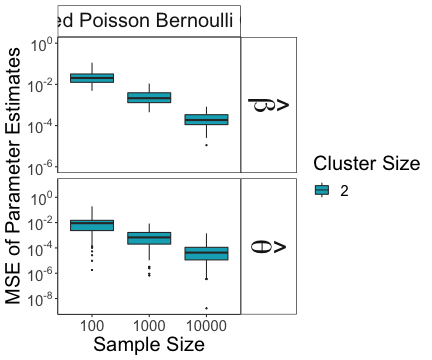

RObject{VecSxp}


In [13]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-6]
msedfR[parameters == "beta",y_max := 10^0]
msedfR[parameters == "theta",y_min := 10^-5]
msedfR[parameters == "theta",y_max := 10^1]
# msedfR[parameters == "rho",y_min := 10^-9]
# msedfR[parameters == "rho",y_max := 10^-2]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('2'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('100', '1000', '10000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'theta'), labels = c(beta = expression(hat(bold(beta))), theta = expression(hat(bold(theta)))))
msedfR$robust = factor(msedfR$robust, levels = c('Bivariate Mixed Poisson Bernoulli Quasi-Copula'),
    labels = c(expression(paste("Bivariate Mixed Poisson Bernoulli Quasi-Copula")))) # , expression(paste("MvT Gamma Inverse-Gamma"))))


#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=15),
        axis.text.y = element_text(angle=0, size=15), axis.title.x = element_text(size = 20), 
        axis.title.y = element_text(size = 20), legend.title = element_text(size = 20),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=15), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(size=30, face="bold"),
        strip.text.x = element_text(size=20)) + 
  scale_fill_manual(values = c("#05aec0")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Sample Size", y = "MSE of Parameter Estimates", fill = "Cluster Size") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 

"""

In [14]:
R"""
ggsave('updated_msefacetplot_biv_mixed_poisson_bernoulli.png', mseplot, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "updated_msefacetplot_biv_mixed_poisson_bernoulli.png"
